***Task***

Reddit comments: Data

10 words->sentence length

10 words+eos

preprocessing

one hot encoding and word2vec

Transformer(single head)

class

In [ ]:
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
import torch.nn as nn
from tensorflow import keras
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers.legacy import Adam
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
import gensim.downloader
from sklearn.metrics import f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
def tenwords(str):
  tokens=str.split()[:10]
  str1=''

  for i in range(len(tokens)):
    if i==0:
      str1+=tokens[i]
    else:

      str1=str1+" "+tokens[i]
  return str1.lower()

In [ ]:
def cleaningPunc(str):
  str=re.sub(r'[^\w\s]','',str)
  return str

In [ ]:
def urlremove(sentence):
  sentence=re.sub(r'http\S+', '', sentence)
  sentence=re.sub(r'www\S+', '', sentence)
  return sentence


In [ ]:
def stopwordsRemove(str):
  str1=""
  stop_words=stopwords.words('english')
  str=str.split()

  for word in str:
    if not word in stop_words:
      str1+=word+' '
  return str1


In [ ]:
def cleaningdigits(str):
  str=re.sub(r'[\d+]','',str)
  return str

In [ ]:
def lemmatization(str):
  lemma=WordNetLemmatizer()
  str1=''
  tokens=str.split()
  for word in tokens:
    store=lemma.lemmatize(word)
    str1+=store+' '
  return str1.lower()


In [ ]:
url='https://drive.google.com/file/d/12bhIJ9uIO4npZzq9Y4xt15WvZme6p9zn/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)



#df=pd.read_csv('reddit_data.csv')
df.drop('parent_id',inplace=True,axis=1)
df.drop('length',inplace=True,axis=1)
df.drop('size_range',inplace=True,axis=1)
df=df.drop_duplicates()

df=df[df['text'].notnull()]
df=df[df['topic'].notnull()]



label_encoder=preprocessing.LabelEncoder()
df['topic']=label_encoder.fit_transform(df['topic'])

text=df['text'].to_numpy()
topic=df['topic'].to_numpy()
x_train,x_test,y_train,y_test=train_test_split(text,topic,test_size=0.3)

print(x_train.shape)





(26824,)


In [ ]:
for i in range(len(x_train)):
  sentence=x_train[i]

  sentence=tenwords(sentence)

  sentence=cleaningPunc(sentence)

  sentence=stopwordsRemove(sentence)

  sentence=cleaningdigits(sentence)

  sentence=lemmatization(sentence)

  sentence=urlremove(sentence)
  x_train[i]=sentence


In [ ]:
for i in range(len(x_test)):
  sentence=x_test[i]

  sentence=tenwords(sentence)

  sentence=cleaningPunc(sentence)

  sentence=stopwordsRemove(sentence)

  sentence=cleaningdigits(sentence)

  sentence=lemmatization(sentence)

  sentence=urlremove(sentence)
  x_test[i]=sentence

In [ ]:
#new_model= gensim.downloader.load('fasttext-wiki-news-subwords-300')
new_model=gensim.downloader.load('glove-twitter-25')
new_model.most_similar("bad")

[('shit', 0.9544215202331543),
 ('crazy', 0.9532092809677124),
 ('but', 0.9522292017936707),
 ('hell', 0.9521805047988892),
 ('right', 0.9486410617828369),
 ('like', 0.9483203291893005),
 ('same', 0.9475184679031372),
 ('damn', 0.94697105884552),
 ('thing', 0.9445645213127136),
 ('way', 0.9423031210899353)]

In [ ]:
word='eating'
vec=new_model[word]
print(len(vec))



25


Frequency counted for histogram

In [ ]:
token_index={}

counter=0
for sentence in x_train:
  tokens=sentence.split()
  for token in tokens:
    if not token in token_index:
      token_index.update({token:counter})
      counter=counter+1
    else:
      token_index[token]=counter
      counter=counter+1

print(len(token_index))
print(type(token_index))


16179
<class 'dict'>


(16179,)


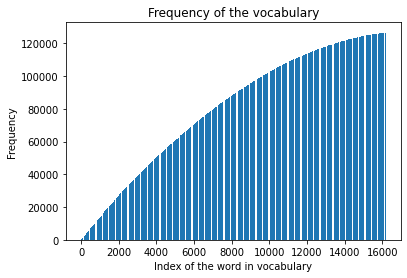

In [ ]:
token_index_list=sorted(token_index.items(), key=lambda x:x[1])
arr=np.zeros((len(token_index)))
index=np.arange(len(token_index))
for i,token in enumerate(token_index_list):
  arr[i]=token[1]
print(arr.shape)
plt.bar(index, arr)
plt.title('Frequency of the vocabulary')
plt.xlabel('Index of the word in vocabulary')
plt.ylabel('Frequency')
plt.show()




In [ ]:
n=99.50

reduce=(n/100)
reduce=round(reduce*len(token_index))
token_index_list=sorted(token_index.items(),key=lambda x:x[1])

reduce=round((reduce/2))

for i,token in enumerate(token_index_list):
  token_index.pop(token[0])
  if(i==reduce):
    break

token_index_list=sorted(token_index.items(),key=lambda x:x[1], reverse=True)
for i,token in enumerate(token_index_list):
  token_index.pop(token[0])
  if(i==reduce):
    break
print(len(token_index))


79


In [ ]:
maxlen=len(token_index)
wv_size=len(vec)
results  = np.zeros(shape = (len(x_train),
                            maxlen,
                            wv_size))
print(results.shape)

results_test  = np.zeros(shape = (len(x_test),
                            maxlen,
                            wv_size))
print(results_test.shape)

(26824, 79, 25)
(11497, 79, 25)


In [ ]:
for i, documents in enumerate(x_train):
  for j, considered_word in list(enumerate(documents.split())):
    try:
      results[i, j, :] = new_model[considered_word]
    except:
      results[i,j,:]=np.zeros((wv_size))




In [ ]:
for i, documents in enumerate(x_test):
  for j, considered_word in list(enumerate(documents.split())):
    try:
      results[i, j, :] = new_model[considered_word]
    except:
      results[i,j,:]=np.zeros((wv_size))


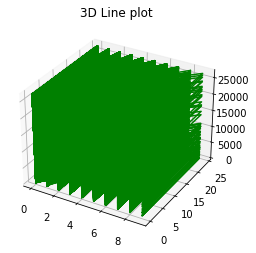

In [ ]:
##not run##
fig = plt.figure()
ax = plt.axes(projection='3d')
z, x, y = results.nonzero()
ax.plot3D (x, y, z, 'green')
#ax.plot_surface(x, y, z,cmap='magma', edgecolor='none')
ax.set_title('3D Line plot')
plt.show()

In [ ]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, ff_dim, num_heads=1, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"),
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self):
        super(TokenAndPositionEmbedding, self).__init__()


    def call(self, x):
      document_len=len(x)
      n=10000
      #positions=np.zeros((document_len,maxlen,vocab_size))
      positions=np.zeros((maxlen,vocab_size))
      for i in range(document_len):
        for j in range(maxlen):
          for k in np.arange(int(vocab_size/2)):
            denominator=np.power(n,2*k/vocab_size)
            positions[j,2*k]=np.sin(j/denominator)
            positions[j,2*k+1]=np.cos(j/denominator)

      return x + positions

In [ ]:
##not run##
vocab_size=wv_size
ff_dim = 32  # Hidden layer size in feed forward network inside transformer


embedding_layer1 = TokenAndPositionEmbedding()
x = embedding_layer1(results)

transformer_block1 = TransformerBlock(wv_size, ff_dim)
x=transformer_block1(x)
data=x


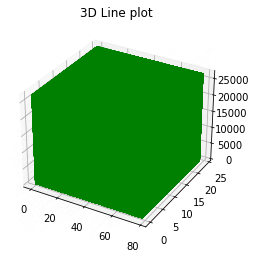

In [ ]:
##not run##
data=data.numpy()
fig = plt.figure()
ax = plt.axes(projection='3d')
z, x1, y = data.nonzero()
ax.plot3D (x1, y, z, 'green')
#ax.plot_surface(x, y, z,cmap='magma', edgecolor='none')
ax.set_title('3D Line plot')
plt.show()

In [ ]:
vocab_size=wv_size
ff_dim = 32  # Hidden layer size in feed forward network inside transformer


embedding_layer = TokenAndPositionEmbedding()

transformer_block = TransformerBlock(wv_size, ff_dim)


inputs = Input(shape=(maxlen,vocab_size))
x = embedding_layer(inputs)

x=transformer_block(x)
x=transformer_block(x)
x=transformer_block(x)
x=transformer_block(x)
x=transformer_block(x)
x=transformer_block(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(6, activation="softmax")(x)
print(outputs.shape)
model = Model(inputs=inputs, outputs=outputs)

(None, 6)


In [ ]:

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(results, y_train,
                    batch_size=128, epochs=32,

                   )

Epoch 1/32
210/210 [==============================] - 79s 340ms/step - loss: 1.5890 - accuracy: 0.2602
Epoch 2/32
210/210 [==============================] - 71s 338ms/step - loss: 1.5347 - accuracy: 0.3179
Epoch 3/32
210/210 [==============================] - 72s 342ms/step - loss: 1.4956 - accuracy: 0.3616
Epoch 4/32
210/210 [==============================] - 72s 343ms/step - loss: 1.4727 - accuracy: 0.3805
Epoch 5/32
210/210 [==============================] - 72s 343ms/step - loss: 1.4610 - accuracy: 0.3886
Epoch 6/32
210/210 [==============================] - 76s 363ms/step - loss: 1.4554 - accuracy: 0.3913
Epoch 7/32
210/210 [==============================] - 70s 334ms/step - loss: 1.4515 - accuracy: 0.3953
Epoch 8/32
210/210 [==============================] - 70s 334ms/step - loss: 1.4489 - accuracy: 0.3940
Epoch 9/32
210/210 [==============================] - 70s 333ms/step - loss: 1.4421 - accuracy: 0.3975
Epoch 10/32
210/210 [==============================] - 70s 333ms/step - l

In [ ]:
results_calc = model.evaluate(results_test, y_test, verbose=2)

for name, value in zip(model.metrics_names, results_calc):
    print("%s: %.3f" % (name, value))

360/360 - 13s - loss: 1.7368 - accuracy: 0.2317 - 13s/epoch - 37ms/step
loss: 1.737
accuracy: 0.232


In [ ]:
y_train=y_train[:len(y_test)]
macro_f1_score= f1_score(y_train, y_test, average='macro')
print(macro_f1_score)

0.17332027677170958
